In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from splitter import splitter  # import your function from splitter.py
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score

plt.rcParams['figure.figsize'] = [13, 7]

df = pd.read_csv("topic21_v9_train.csv")
print(df)

             0         1          2         3         4          brand  \
0          NaN  3.764959   3.686498  0.504080  2.816529  Mercedes-Benz   
1     0.500825  3.509076  14.804767  0.244597 -0.876152          Tesla   
2     1.915838  3.711548   7.975758  0.651522  3.378688           Audi   
3     0.279719  3.842128   5.903154  0.313971  2.489437        Bentley   
4     0.689781  3.613425   8.651282  0.273852  1.337020        Peugeot   
...        ...       ...        ...       ...       ...            ...   
7957  2.905641       NaN  23.191578  0.476294  0.206035     Land Rover   
7958  0.434064  3.603330  11.182552  0.413911  0.114275        Renault   
7959  0.804830  3.575916  25.227375  0.345557  0.457583  Mercedes-Benz   
7960  0.352151  3.602651  -0.568026  0.254414 -0.054873  Mercedes-Benz   
7961  2.205537  3.653822  16.434068  0.881862  2.213762           Ford   

                  model         trim             body_type fuel_type  \
0               M-Class       ML 500   

In [79]:
print(df.columns)

df_num = df.drop(columns=["brand", "model", "trim", "body_type",
       "fuel_type", "transmission_type", "engine_capacity_cc", "horsepower",
       "exterior_color", "interior_color", "warranty", "city", "seller_type"]) #Dropping non-numerical cols

df_num.isna().sum()
df_num_filled = df_num.fillna(df_num.mean(numeric_only=True)) #Filling NANS
print("Filled NaNs", df_num_filled.isna().sum())

df_num_clean = df_num.dropna()
print("Dropped NaNs", df_num_clean.isna().sum())

Index(['0', '1', '2', '3', '4', 'brand', 'model', 'trim', 'body_type',
       'fuel_type', 'transmission_type', 'engine_capacity_cc', 'horsepower',
       'exterior_color', 'interior_color', 'warranty', 'city', 'seller_type',
       'price'],
      dtype='object')
Filled NaNs 0        0
1        0
2        0
3        0
4        0
price    0
dtype: int64
Dropped NaNs 0        0
1        0
2        0
3        0
4        0
price    0
dtype: int64


In [80]:
# X = df_num_filled.drop(columns=["price"])  
# y = df_num_filled["price"] 
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# model = LinearRegression()
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)
# mae = mean_absolute_error(y_test, y_pred)
# rmse = np.sqrt(mse)

# print(f"Mean Squared Error: {mse:.2f}")
# print(f"Root Mean Squared Error: {rmse:.2f}")
# print(f"Mean Average Error: {mae: .2f}")
# print(f"R² Score: {r2:.2f}")

# plt.figure(figsize=(10, 6))
# sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='blue')
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')  # Perfect prediction line
# plt.xlabel("Actual Price")
# plt.ylabel("Predicted Price")
# plt.title("Actual vs. Predicted Car Prices")
# plt.grid(True)
# plt.show()

In [81]:

# X = df_num_clean.drop(columns=["price"])
# y = df_num_clean["price"]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# model = LinearRegression()
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)
# mae = mean_absolute_error(y_test, y_pred)
# rmse = np.sqrt(mse)

# print(f"Mean Squared Error: {mse:.2f}")
# print(f"Root Mean Squared Error: {rmse:.2f}")
# print(f"Mean Average Error: {mae: .2f}")
# print(f"R² Score: {r2:.2f}")

# plt.figure(figsize=(10, 6))
# sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='blue')
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')  # Perfect prediction line
# plt.xlabel("Actual Price")
# plt.ylabel("Predicted Price")
# plt.title("Actual vs. Predicted Car Prices")
# plt.grid(True)
# plt.show()
print("Min price:", df_num["price"].min())
print("Max price:", df_num["price"].max())

Min price: 1000
Max price: 999900


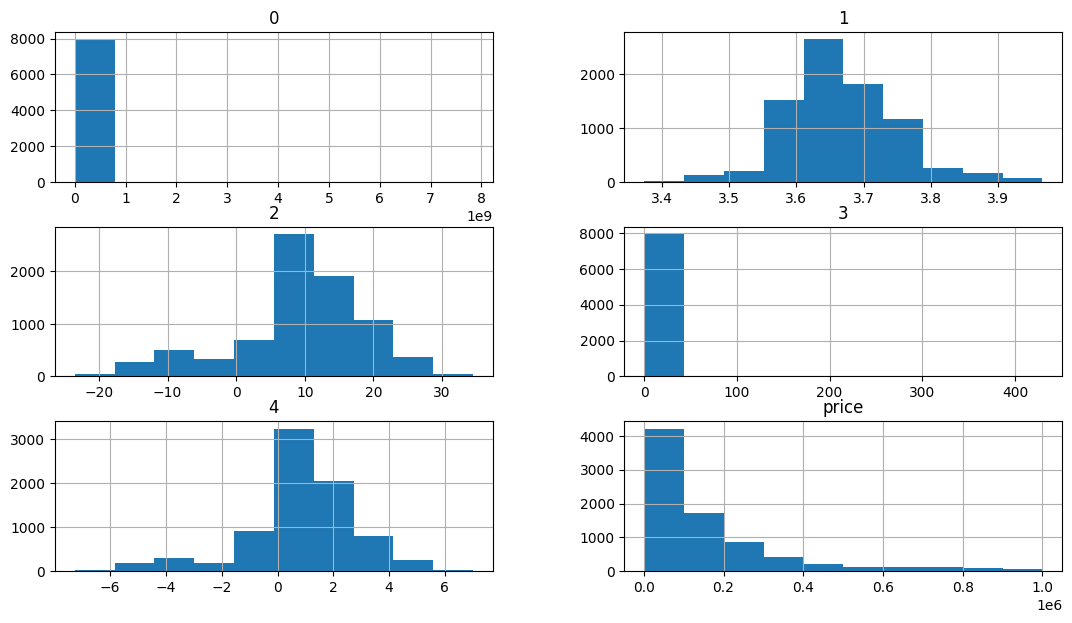

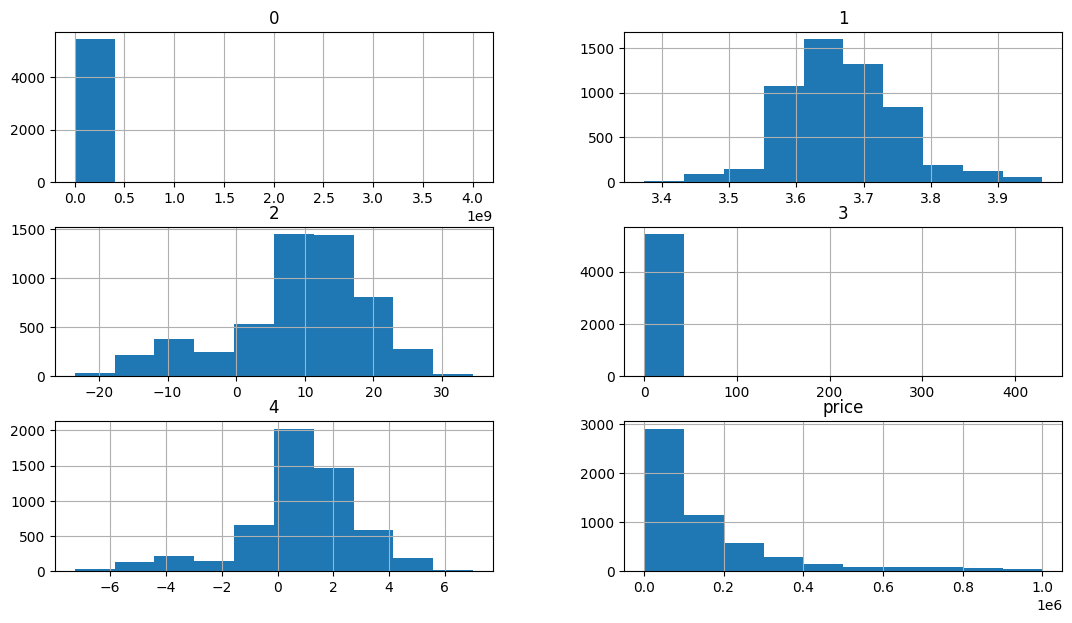

Min 0: 0.2504974182953935
Max 0: 7834847414.898069
Min 0: 0.2504974182953935
Max 0: 7834847414.898069


In [100]:
df_num_filled.hist()
plt.show()

df_num_clean.hist()
plt.show()

print("Min 0:", df_num["0"].min())
print("Max 0:", df_num["0"].max())
print("Min 0:", df_num["0"].min())
print("Max 0:", df_num["0"].max())

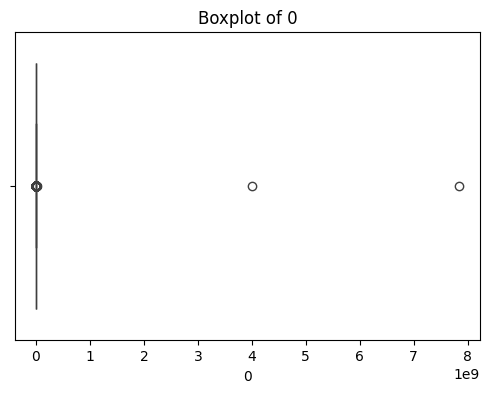

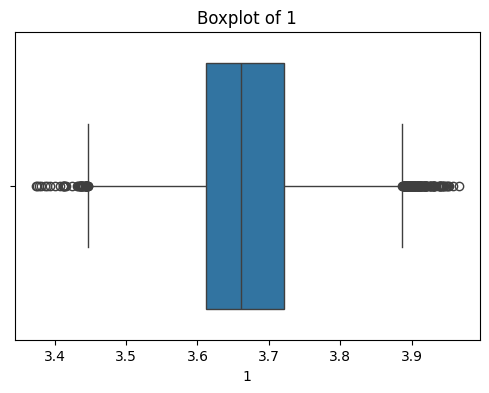

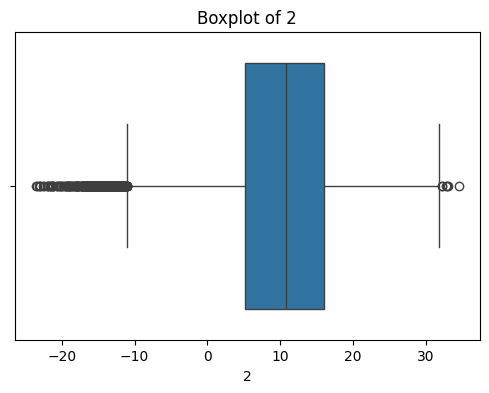

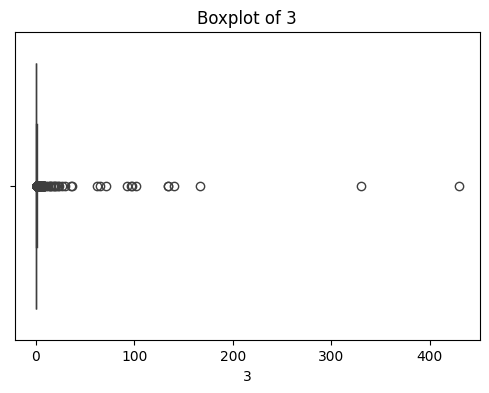

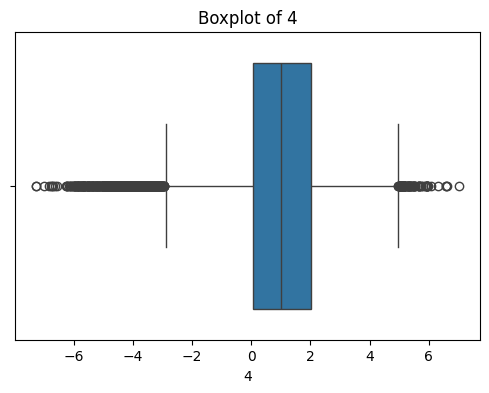

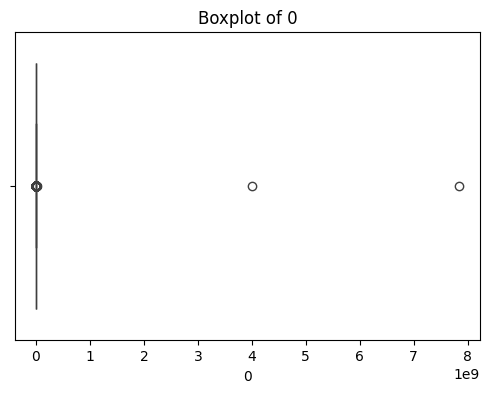

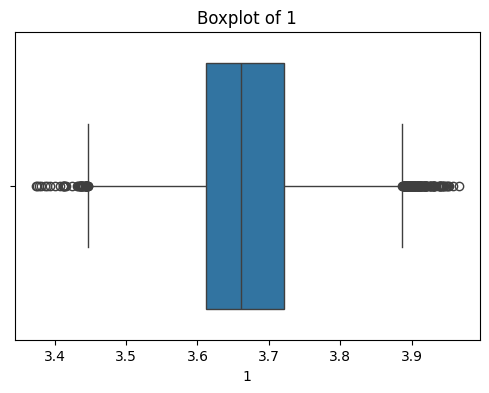

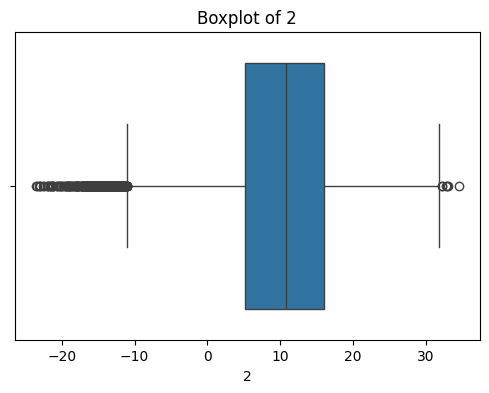

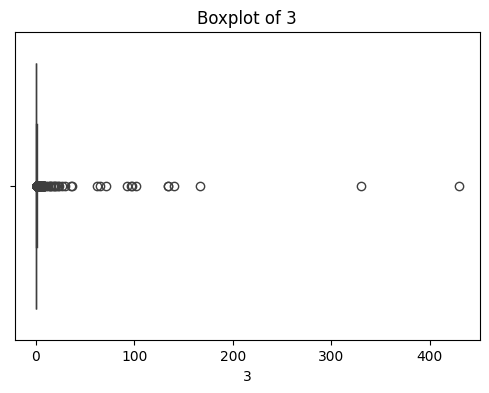

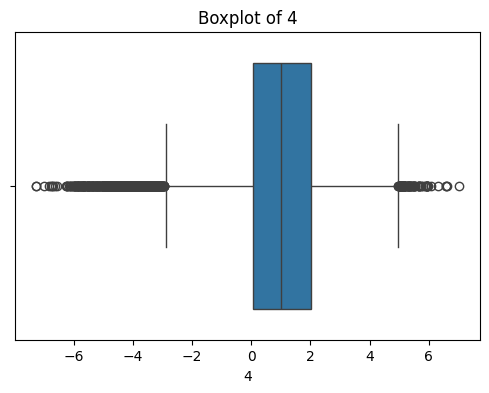

Min price: 1000
Max price: 999900
Min price: 1000
Max price: 999900


In [83]:
cols1 = df_num_filled.columns[:5]  # features 0 to 4

for col in cols1:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df_num[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

cols2 = df_num_filled.columns[:5]  # features 0 to 4

for col in cols2:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df_num[col])
    plt.title(f"Boxplot of {col}")
    plt.show()


print("Min price:", df_num_filled["price"].min())
print("Max price:", df_num_filled["price"].max())
print("Min price:", df_num_clean["price"].min())
print("Max price:", df_num_clean["price"].max())

In [104]:
Q1 = df_num_clean["0"].quantile(0.25)
Q3 = df_num_clean["0"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_col0 = df[df["0"] < lower_bound] | df[df["0"] > upper_bound]
df.loc[outliers_col0.index]

,0,1,2,3,4,brand,model,trim,body_type,fuel_type,transmission_type,engine_capacity_cc,horsepower,exterior_color,interior_color,warranty,city,seller_type,price
8,3.454998,3.759857,7.482965,0.821301,1.597708,Land Rover,Range Rover Sport,Supercharged,SUV,Petrol,Automatic Transmission,NaN,300 - 399 HP,Blue,White,Does not apply,Sharjah,Owner,18000
16,2.869139,NaN,-7.965460,0.848802,0.123001,Nissan,Altima,S,Coupe,Petrol,Automatic Transmission,2500 - 2999 cc,Unknown,Black,Beige,No,Dubai,Owner,14000
53,2.498569,3.553889,21.649448,NaN,-0.999632,Nissan,Sunny,S,Sedan,Petrol,Automatic Transmission,1500 - 1999 cc,0 - 99 HP,White,Brown,Does not apply,Dubai,Owner,17500
64,6.946205,3.617998,13.969692,0.753511,1.169911,Nissan,Altima,S,Sedan,Petrol,Automatic Transmission,2000 - 2499 cc,100 - 199 HP,White,Beige,Does not apply,Dubai,Owner,10500
100,2.332090,3.605659,19.960028,0.564226,-0.079968,Hyundai,Accent,GL,Sedan,Petrol,Automatic Transmission,1000 - 1499 cc,200 - 299 HP,Silver,White,No,Dubai,Dealer,16500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7919,6.995754,3.611021,17.721368,1.210672,0.371527,Kia,Sportage,EX,SUV,Petrol,Automatic Transmission,0 - 499 cc,100 - 199 HP,Red,Beige,No,Dubai,Owner,12000
7936,2.390403,3.736749,18.600095,0.411802,0.996020,BMW,X5,Xdrive50i,SUV,Petrol,Automatic Transmission,4000+ cc,400 - 499 HP,Black,Beige,No,Abu Dhabi,Dealer,168000
7943,3.985709,3.697439,NaN,1.141491,4.027144,Mitsubishi,Pajero,GLS 5 Door,SUV,Petrol,Automatic Transmission,3500 - 3999 cc,300 - 399 HP,Grey,Beige,Does not apply,Dubai,Owner,19000
7952,3.830692,3.640670,7.940704,0.653922,0.850349,Honda,Accord,LX,Sedan,Petrol,Automatic Transmission,2000 - 2499 cc,100 - 199 HP,White,Beige,Does not apply,Dubai,Owner,21000


Min price: 1000
Max price: 999900
Min price: 1000
Max price: 999900


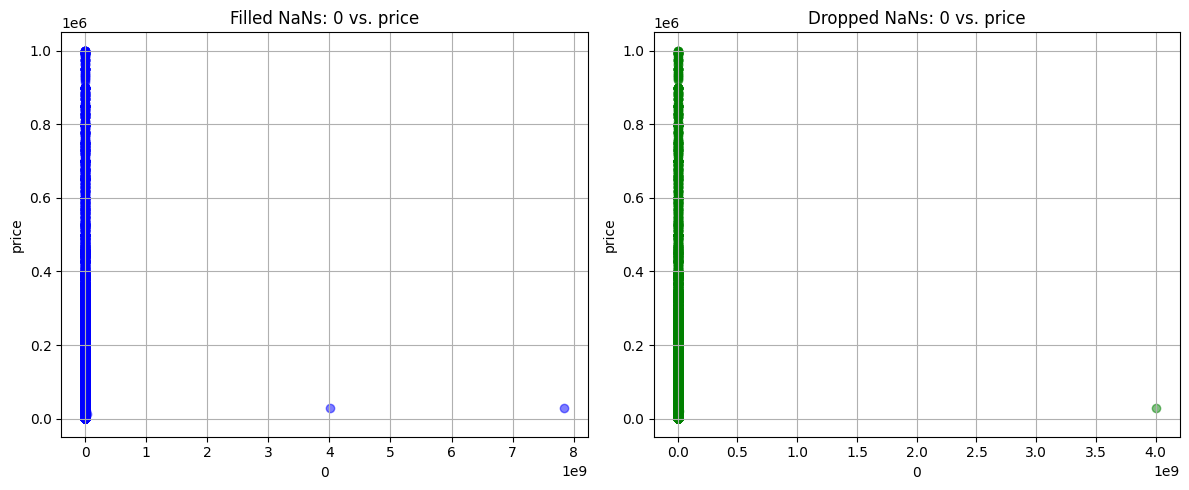

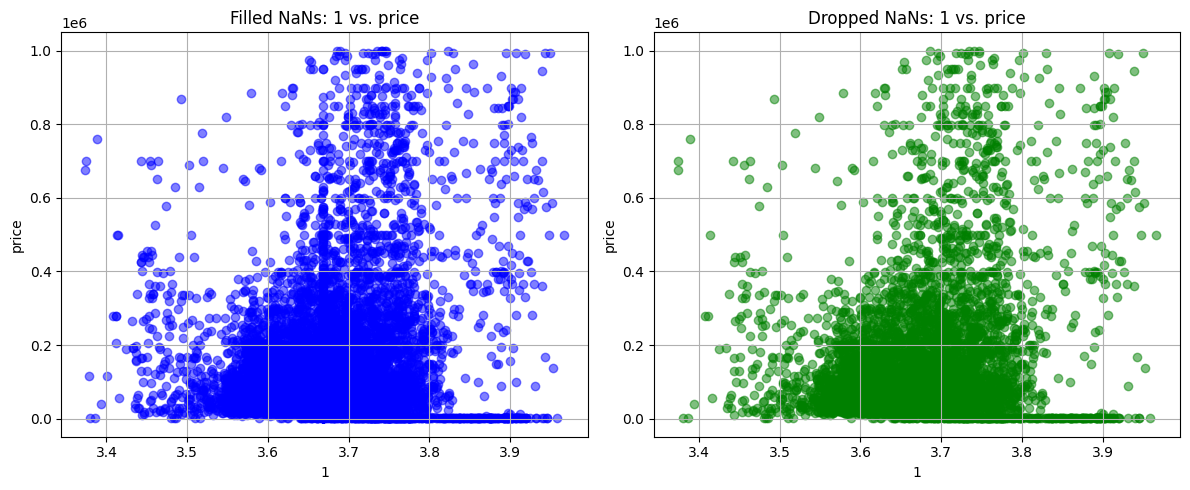

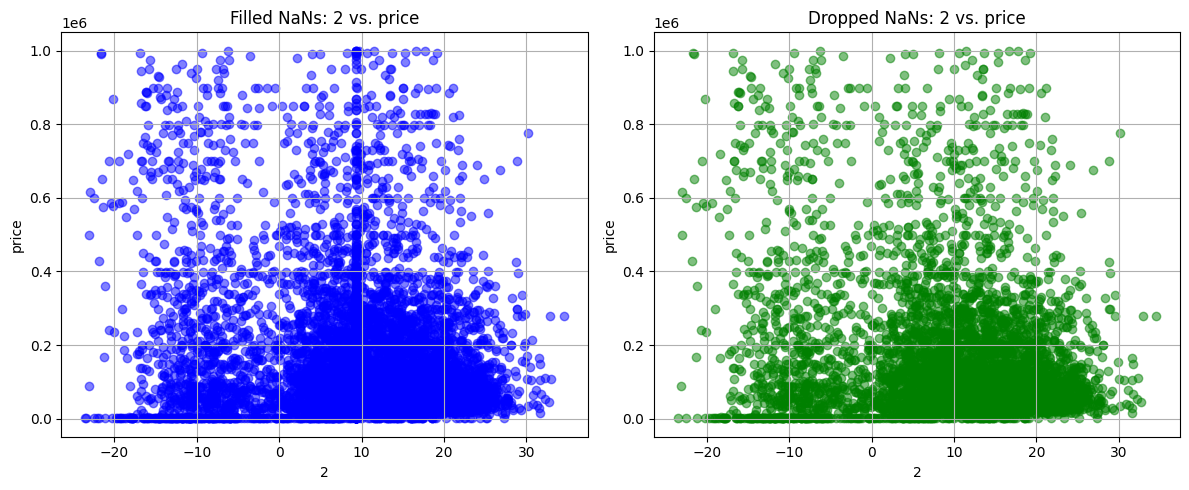

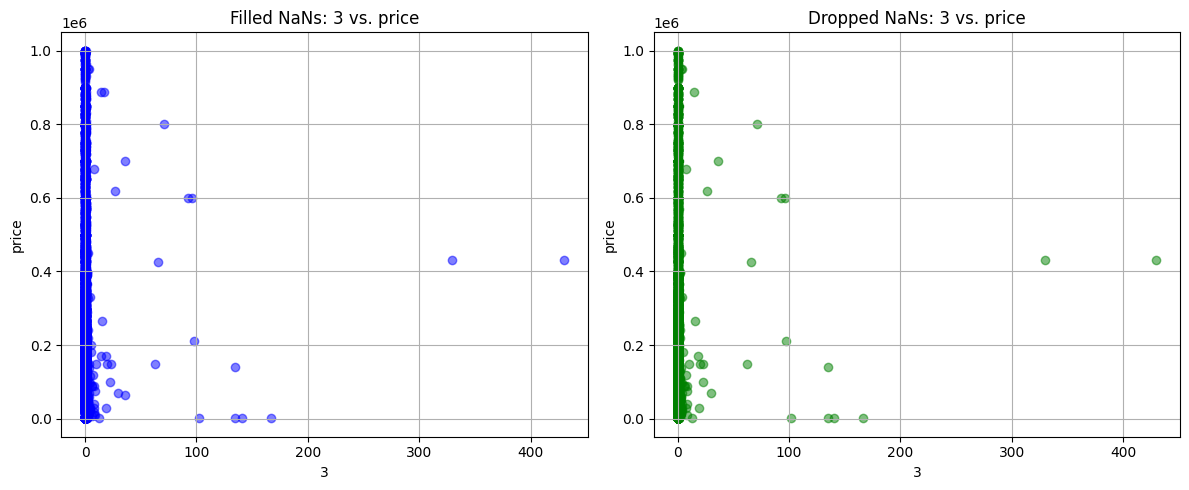

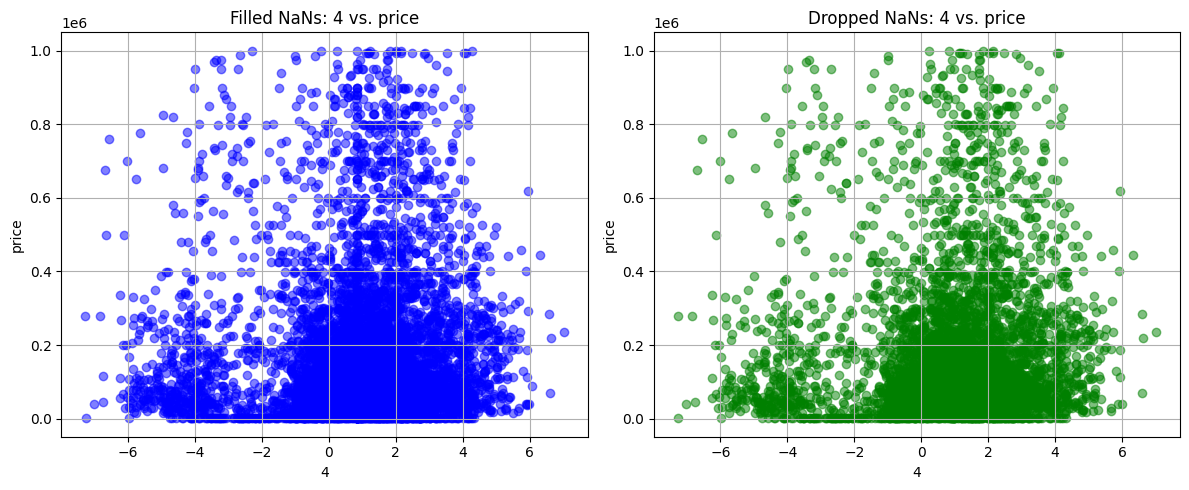

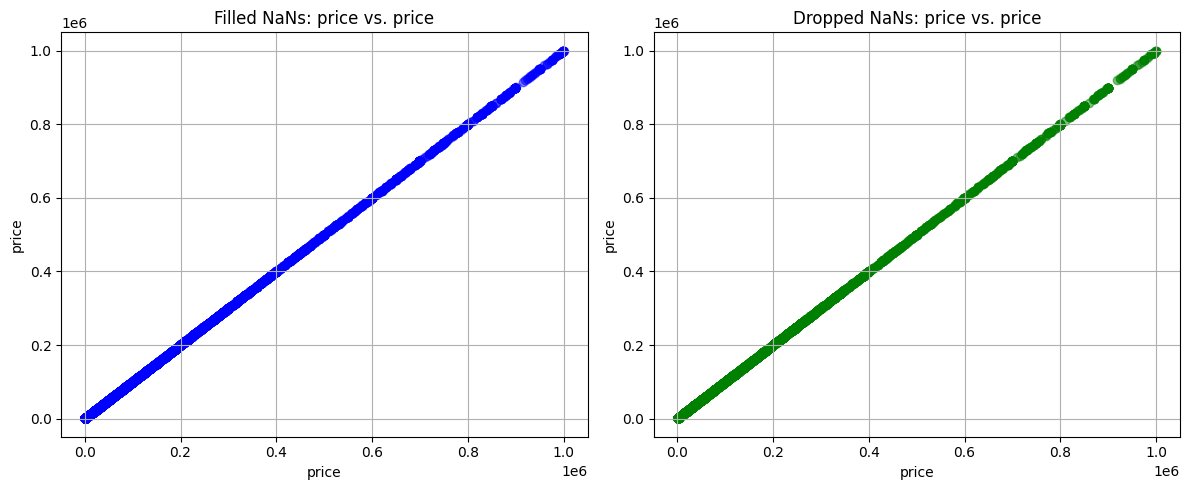

In [105]:
print("Min price:", df_num_filled["price"].min())
print("Max price:", df_num_filled["price"].max())
print("Min price:", df_num_clean["price"].min())
print("Max price:", df_num_clean["price"].max())

features = df_num

# Plot for each feature in two rows (filled vs. clean)
for feature in features:
    plt.figure(figsize=(12, 5))

    # Scatterplot: df_num_filled
    plt.subplot(1, 2, 1)
    plt.scatter(df_num_filled[feature], df_num_filled["price"], alpha=0.5, color="blue")
    plt.title(f"Filled NaNs: {feature} vs. price")
    plt.xlabel(feature)
    plt.ylabel("price")
    plt.grid(True)

    # Scatterplot: df_num_clean
    plt.subplot(1, 2, 2)
    plt.scatter(df_num_clean[feature], df_num_clean["price"], alpha=0.5, color="green")
    plt.title(f"Dropped NaNs: {feature} vs. price")
    plt.xlabel(feature)
    plt.ylabel("price")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [93]:
# Provide the path to your CSV file
file_path = "topic21_v9_train.csv"

# Split the data
X_train, X_test, y_train, y_test = splitter(file_path)

# Optional: check the shapes
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (6369, 18)
X_test: (1593, 18)
y_train: (6369,)
y_test: (1593,)


***1. Outlier Filtering on X_train (3σ rule)***

In [85]:
# Identify numeric columns in X_train
numeric_cols = X_train.select_dtypes(include=np.number).columns

# Calculate z-scores
z_scores = (X_train[numeric_cols] - X_train[numeric_cols].mean()) / X_train[numeric_cols].std()

# Keep rows where all z-scores are within ±3
mask = (np.abs(z_scores) <= 3).all(axis=1)

# Apply mask to both X_train and y_train
X_train_clean = X_train[mask].reset_index(drop=True)
y_train_clean = y_train[mask].reset_index(drop=True)

print("Cleaned X_train:", X_train_clean.shape)


Cleaned X_train: (4265, 5)


***2. Split a Validation Set from the Cleaned Training Data***

In [86]:
# 20% validation set from the cleaned training data
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_clean, y_train_clean, test_size=0.2, random_state=42
)

print("Train set:", X_train_final.shape)
print("Validation set:", X_val.shape)

Train set: (3412, 5)
Validation set: (853, 5)


***3. Preprocessing Setup: Imputation, Scaling, One-Hot Encoding***

In [87]:
# Identify categorical and numerical columns
categorical_cols = X_train.select_dtypes(include="object").columns
numerical_cols = X_train.select_dtypes(include=np.number).columns

# Define transformers
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# Combine transformers into a ColumnTransformer
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numerical_cols),
    ("cat", categorical_transformer, categorical_cols)
])


***4. Build Pipeline and Do Cross-Validation***

In [88]:
# Final pipeline
pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

# Cross-validation on training set
cv_results = cross_validate(pipe, X_train_final, y_train_final, cv=5,
                            scoring="neg_mean_squared_error", return_train_score=True)

# Print mean CV scores
print("Mean CV MSE:", -np.mean(cv_results["test_score"]))

Mean CV MSE: 32566005964.698708


***5. Evaluate on Held-Out Validation Set***


In [89]:
# Fit on train split and predict on validation split
pipe.fit(X_train_final, y_train_final)
y_val_pred = pipe.predict(X_val)

# Compute validation MSE
val_mse = mean_squared_error(y_val, y_val_pred)
print("Validation MSE:", val_mse)


Validation MSE: 33592475406.846066


In [90]:
# MSE
val_mse = mean_squared_error(y_val, y_val_pred)

# MAE
val_mae = mean_absolute_error(y_val, y_val_pred)

# RMSE
val_rmse = np.sqrt(val_mse)

# R^2 Score
val_r2 = r2_score(y_val, y_val_pred)

# Print all metrics
print(f"Validation MSE:  {val_mse:.4f}")
print(f"Validation MAE:  {val_mae:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Validation R²:   {val_r2:.4f}")

Validation MSE:  33592475406.8461
Validation MAE:  124061.0491
Validation RMSE: 183282.5016
Validation R²:   0.1236


***Trying feature engineering***

In [91]:
from sklearn.preprocessing import FunctionTransformer

def add_custom_features(X):
    X = X.copy()
    
    # Example 1: Create a ratio of two existing columns
    if 'feature1' in X.columns and 'feature2' in X.columns:
        X['feature1_to_feature2'] = X['feature1'] / (X['feature2'] + 1e-5)
    
    # Example 2: Log-transform a numeric feature
    if 'price' in X.columns:
        X['log_price'] = np.log1p(X['price'])

    # Example 3: Interaction term
    if 'age' in X.columns and 'income' in X.columns:
        X['age_income_interaction'] = X['age'] * X['income']

    return X

feature_engineering = FunctionTransformer(add_custom_features)


In [92]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Add the transformer before preprocessing
pipe = Pipeline([
    ('feature_engineering', feature_engineering),
    ('preprocessor', preprocessor),
    ('regressor', model)
])